Реализовать с помощью объектно-ориентированного подхода предыдущие 2 задания. Создайте для каждой из задач отдельный класс, который позволяет ее решить.
<ul>
<li/>Собрать информацию о всех строящихся объектах на сайте "наш.дом.рф"

<li/>Cохранить ее в pandas dataframe, а также в excel, pickle, БД

<li/>Проверить состояние датафрейма и привести его в формат, позволяющий дальнейшее исследование данных

<li/>Сделать визуализацию для мини-исследования рынка строящейся недвижимости в одном или нескольких регионах с помощью pandas, matplotlib, seaborn, plotly и других инструментов.
</ul>


In [1]:
import requests
import pandas as pd
from tqdm.auto import tqdm
from collections import defaultdict
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
from pylab import rcParams
%matplotlib inline

In [2]:
class DomIdLoader:
    def __init__(self):
        self.offset_ = 0
        self.limit_ = 100
        self.url = f'https://xn--80az8a.xn--d1aqf.xn--p1ai/%D1%81%D0%B5%D1%80%D0%B2%D0%B8%D1%81%D1%8B/api/kn/object'
        self.num_pages = None
        self.objects_data = []

    def get_ids(self):
        self.num_pages = math.ceil(requests.get(self.url, params={'objStatus': '0'}) \
                                   .json().get('data').get('total')/self.limit_)
        
        for i in tqdm(range(self.num_pages)):
            try:
                res = requests.get(self.url, params={'limit': self.limit_, 
                                                'offset': self.offset_, 
                                                'objStatus': '0', 
                                                'sortField': 'devId.devShortCleanNm',
                                                'sortType': 'asc'})
                self.offset_ += self.limit_
                objects_list = res.json().get('data').get('list')
                self.objects_data.extend([x.get('objId') for x in objects_list])
            except:
                continue

    def show_ids(self):
        print(self.objects_data)

In [3]:
class ObjectInfoExtractor(DomIdLoader):
    def __init__(self):
        self.dom_info = defaultdict(list)
        self.df = None
        super().__init__()

    def load_data(self):
        for objid in tqdm(self.objects_data):
            try:
                url = f'https://xn--80az8a.xn--d1aqf.xn--p1ai/%D1%81%D0%B5%D1%80%D0%B2%D0%B8%D1%81%D1%8B/api/object/{objid}'
                res = requests.get(url)
                data = res.json().get('data')
                self.dom_info['id'].append(data.get('id'))
                self.dom_info['Developer_Nm'].append('{} {}'.format(data.get('developer').get('orgForm').get('shortForm'), 
                                                            data.get('developer').get('devFullCleanNm')))
                self.dom_info['Building_Region'].append(data.get('region'))
                self.dom_info['Data_Finish'].append(data.get('objReady100PercDt'))
                self.dom_info['Floor_Cnt'].append(data.get('objFloorCnt'))
                self.dom_info['Price_Avg'].append(data.get('objPriceAvg'))
                self.dom_info['Living_Cnt'].append(data.get('objElemLivingCnt'))
                self.dom_info['Square_Living'].append(data.get('objSquareLiving'))
                self.dom_info['Parking_Cnt'].append(data.get('objElemParkingCnt'))
                self.dom_info['soldOutPerc'].append(data.get('soldOutPerc'))
                self.dom_info['objLkClassDesc'].append(data.get('objLkClassDesc'))
                self.dom_info['wallMaterialShortDesc'].append(data.get('wallMaterialShortDesc'))
                self.dom_info['objLkFinishTypeDesc'].append(data.get('objLkFinishTypeDesc'))
                self.dom_info['objElevatorPassengerCnt'].append(data.get('objElevatorPassengerCnt'))
                self.dom_info['objElevatorCargoCnt'].append(data.get('objElevatorCargoCnt'))
                self.dom_info['objInfrstrPlaygrndCnt'].append(data.get('objInfrstrPlaygrndCnt'))
                self.dom_info['objInfrstrSportGroundCnt'].append(data.get('objInfrstrSportGroundCnt'))
                self.dom_info['objGreenHouseFlg'].append(data.get('objGreenHouseFlg'))
                self.dom_info['objEnergyEffShortDesc'].append(data.get('objEnergyEffShortDesc'))
                self.dom_info['infrastructureIndexValue'].append(data.get('infrastructureIndexValue'))
            except:
                continue

    def df_converter(self):
        self.df = pd.DataFrame(self.dom_info)
        self.df.index += 1
        self.df.Data_Finish = pd.to_datetime(self.df.Data_Finish)
        self.df.Living_Cnt.replace([0], np.NaN, inplace=True)
        self.df.Square_Living.replace([0], np.NaN, inplace=True)
        self.df.objInfrstrPlaygrndCnt.replace([np.NaN], 0, inplace=True)
        self.df.objInfrstrSportGroundCnt.replace([np.NaN], 0, inplace=True)
        self.df['Elevator_Cnt'] = self.df['objElevatorPassengerCnt'] + self.df['objElevatorCargoCnt']
        self.df.drop(['objElevatorPassengerCnt', 'objElevatorCargoCnt'], axis=1, inplace=True)
        self.df['Parking'] = np.where(self.df.Parking_Cnt!=0, 1, 0)
        print('Done')
        
    def df_clean_data(self):
        subst1 = self.df[self.df.Living_Cnt.isna() != True].groupby(['Elevator_Cnt', 'Floor_Cnt']). \
                                agg({'Living_Cnt' : 'mean'}). \
                                reset_index()[['Elevator_Cnt', 'Floor_Cnt', 'Living_Cnt']]

        subst2 = self.df[self.df.Square_Living.isna() != True].groupby(['Elevator_Cnt', 'Floor_Cnt']). \
                                           agg({'Square_Living' : 'mean'}). \
                                           reset_index()[['Elevator_Cnt', 'Floor_Cnt', 'Square_Living']]

        subst3 = self.df[self.df.Price_Avg.isna() != True].groupby(['Building_Region', 'Parking']). \
                                       agg({'Price_Avg' : 'mean'}). \
                                       reset_index()[['Building_Region', 'Parking', 'Price_Avg']]

        subst1.rename(columns={'Elevator_Cnt': 'Elevator_Cnt', \
                               'Floor_Cnt': 'Floor_Cnt', \
                               'Living_Cnt': 'Avg_Living_Cnt_on_Dev'}, inplace=True)
        subst2.rename(columns={'Elevator_Cnt': 'Elevator_Cnt', \
                               'Floor_Cnt': 'Floor_Cnt', \
                               'Square_Living': 'Avg_Living_on_Dev'}, inplace=True)
        subst3.rename(columns={'Building_Region': 'Building_Region', \
                       'Parking': 'Parking',\
                       'Price_Avg': 'Avg_Price_on_Dev'}, inplace=True)
        self.df = self.df.merge(subst1, on=['Elevator_Cnt', 'Floor_Cnt'], how='left').\
               merge(subst2, on=['Elevator_Cnt', 'Floor_Cnt'], how='left').\
               merge(subst3, on=['Building_Region', 'Parking'], how='left')
        self.df['new_Living_Cnt'] = self.df.Living_Cnt.combine_first(self.df.Avg_Living_Cnt_on_Dev)
        self.df['new_Square_Living'] = self.df.Square_Living.combine_first(self.df.Avg_Living_on_Dev)
        self.df['new_Price_Avg'] = self.df.Price_Avg.combine_first(self.df.Avg_Price_on_Dev)
        self.df.drop(self.df[(self.df.new_Living_Cnt.isna() == True) \
         | (self.df.new_Square_Living.isna() == True) \
         | (self.df.new_Price_Avg.isna() == True) \
         | (self.df.infrastructureIndexValue.isna() == True) ].index, axis=0, inplace=True)
        self.df.drop(['Price_Avg', 'Living_Cnt', 'Square_Living', \
         'Avg_Living_Cnt_on_Dev', 'Avg_Living_on_Dev', \
         'Avg_Price_on_Dev'], axis=1, inplace=True)
        self.df.Elevator_Cnt.fillna(0, inplace=True)
        self.df.id = self.df.id.astype('object')
        self.df.Building_Region = self.df.Building_Region.astype('object')
        self.df.objInfrstrPlaygrndCnt  = self.df.objInfrstrPlaygrndCnt.astype('int32')
        self.df.objInfrstrSportGroundCnt = self.df.objInfrstrSportGroundCnt.astype('int32')
        self.df.objGreenHouseFlg = self.df.Parking.astype('object')
        self.df.infrastructureIndexValue = self.df.infrastructureIndexValue.astype('int32')
        self.df.Elevator_Cnt = self.df.Elevator_Cnt.astype('int64')
        self.df.Parking = self.df.Parking.astype('object')
        self.df.new_Living_Cnt = self.df.new_Living_Cnt.astype('int64')
        self.df.Parking_Cnt = self.df.Parking_Cnt.astype('int64')
        print('Done')
        
    def print_sample(self, sample=2):
        return self.df.sample(sample)


In [4]:
class Visualizer(ObjectInfoExtractor):
    def __init__(self):
        super().__init__()

    def make_heatmap(self):
        corr = self.df[~self.df.isnull().any(axis=1)].corr()
        mask = np.zeros_like(corr)
        np.triu_indices_from(mask)
        mask[np.triu_indices_from(mask)] = True
        rcParams['figure.figsize'] = 16,6
        sns.heatmap(corr, mask=mask, vmax=.3, annot=True, fmt='.2f', cmap="inferno")
        
    def make_boxplot(self, x, y):
        rcParams['figure.figsize'] = 16,6
        sns.set(style='darkgrid')
        ax = sns.catplot(data=self.df, \
                    x=x, y=y, \
                    kind='box', orient='h')
        plt.title(f'Распределение {x} в разрезе {y}', fontsize = 25)


In [5]:
class Saver(Visualizer):
    def __init__(self, file_name='default'):
        self.file_name = file_name
        super().__init__()

    def save_csv(self):
        self.df.to_csv(f'{self.file_name}.csv')

    def save_xl(self):
        self.df.to_excel(f'{self.file_name}.xlsx', index=False)
        print('Done')

    def save_sql(self):
        conn = sqlite3.connect(f'{self.file_name}')
        self.df.to_sql(f'{self.file_name}', conn, if_exists='replace', index=False)
        conn.commit()
        conn.close()

In [6]:
User = Saver('d')

In [7]:
User.get_ids()

  0%|          | 0/108 [00:00<?, ?it/s]

In [8]:
User.objects_data = User.objects_data[:500]

In [9]:
User.load_data()

  0%|          | 0/500 [00:00<?, ?it/s]

In [10]:
User.df_converter()

Done


In [11]:
User.df_clean_data()

Done


In [12]:
User.print_sample(1)

,id,Developer_Nm,Building_Region,Data_Finish,Floor_Cnt,Parking_Cnt,soldOutPerc,objLkClassDesc,wallMaterialShortDesc,objLkFinishTypeDesc,objInfrstrPlaygrndCnt,objInfrstrSportGroundCnt,objGreenHouseFlg,objEnergyEffShortDesc,infrastructureIndexValue,Elevator_Cnt,Parking,new_Living_Cnt,new_Square_Living,new_Price_Avg
447,41397,ООО ГЛАВСТРОЙ-СПБ СПЕЦИАЛИЗИРОВАННЫЙ ЗАСТРОЙЩИК,78,2023-12-31,27,0,0.313218,Комфорт,Монолит-кирпич,Под ключ,2,4,0,C,8,4,0,408,17274.67,175898.0


In [13]:
User.save_csv()

In [14]:
User.save_sql()

In [15]:
User.save_xl()

Done


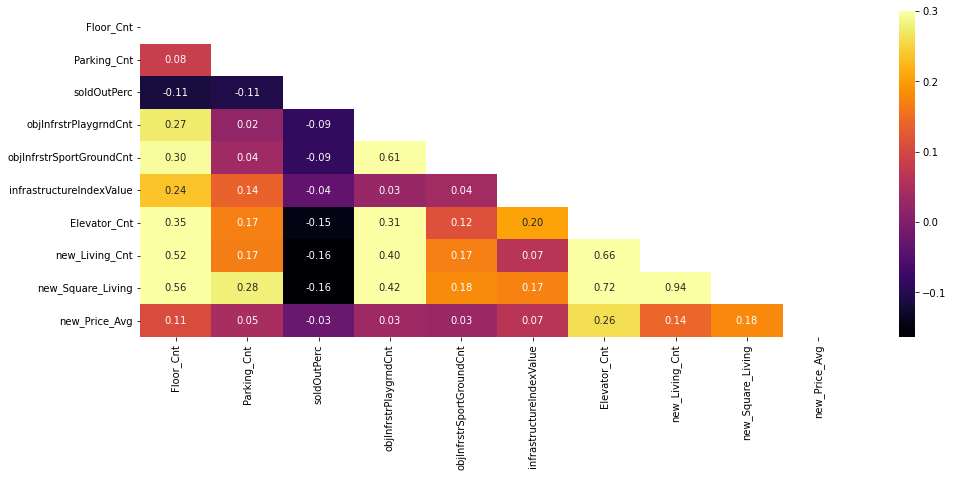

In [16]:
User.make_heatmap()

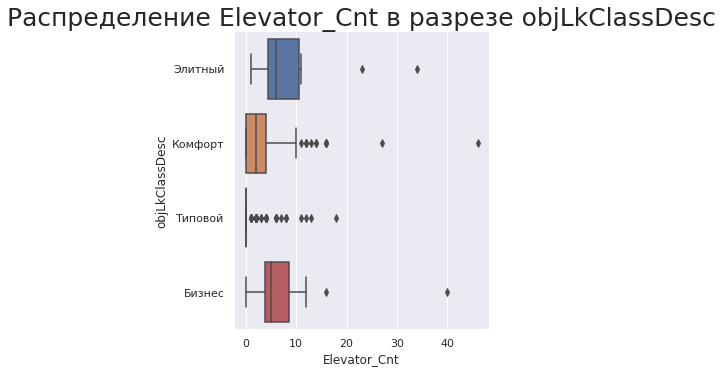

In [18]:
User.make_boxplot(x='Elevator_Cnt', y='objLkClassDesc')

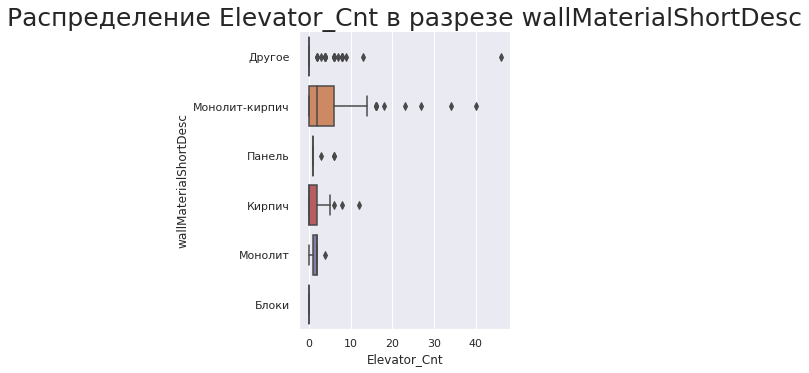

In [22]:
User.make_boxplot(x='Elevator_Cnt', y='wallMaterialShortDesc')